In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from matplotlib.cm import get_cmap
from scipy.stats import spearmanr


In [2]:
def set_layout(ax):
    """统一设置图形样式"""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_linewidth(2)
    ax.spines['left'].set_color('black')
    ax.tick_params(axis='both', which='major', length=6, width=2, direction='out',
                   color='black', labelsize=10, bottom=True, left=True,
                   top=False, right=False)
    ax.grid(False)

In [3]:
# 配置参数
PROJECT_ROOT = Path.cwd()
RESULTS_ROOT = PROJECT_ROOT / "results"

PHASES = ["baseline", "day1", "day2", "day3", "day4"]
SIGNALS = ["win_out", "go_out"]
SAVE_FORMATS = ["png", "pdf"]
SIGNAL_COLORS = {"win_out": "red", "go_out": "blue"}
PLOT_WINDOW = (-1.0, 6.0)
AUC_WINDOW = (0.0, 6.0)

# 高等级配置
HIGH_RANK_CONFIG = {
    "data_root": PROJECT_ROOT / "data" / "results" / "male_high_rank_trials",
    "mouse_ids": [
        "0725-5A", "0725-7C", "0725-7D",
        "0725-9D", "0725-11B", "0725-11C"
    ],
    "pref_path": "male_high_rank_choice_seq.xlsx",
    "label_column": "trial_type",
    "scale_factor": 1,
    'csv_pattern': '*_mPFC.csv'
}

# 低等级配置
LOW_RANK_CONFIG = {
    "data_root": PROJECT_ROOT / "data" / "low rank DA sensor trials",
    "mouse_ids": [
        "0228-11C", "0401-9A", "0401-9C",
        "0620-8A", "0620-8C", "0410-3#3", "0410-3#4"
    ],
    "pref_path": "low rank DA.xlsx",
    "label_column": "label",
    "scale_factor": 100,
    'csv_pattern': '*.csv'
}



In [4]:
def extract_mouse_id(filename: str, mouse_ids: list[str]) -> str:
    """从文件名提取小鼠ID"""
    for mouse_id in mouse_ids:
        if mouse_id in filename:
            return mouse_id
    raise ValueError(f"Mouse ID not found in filename: {filename}")



In [5]:
def load_preference_data(xlsx_path: str) -> pd.DataFrame:
    """加载偏好数据"""
    df = pd.read_excel(xlsx_path)
    mouse_id = df.iloc[:, 0]
    test_day = df.iloc[:, 3]
    preference_ratio = df.iloc[:, 4]

    pref_df = pd.DataFrame({
        "mouse_id": mouse_id,
        "test_day": test_day,
        "preference_ratio": preference_ratio
    })
    return pref_df



In [6]:
def tidy_phase_dataframe(csv_path: Path, config, label_column: str = "trial_type") -> pd.DataFrame:
    """整理单个phase的数据框"""
    raw = pd.read_csv(csv_path, header=None)
    header = raw.iloc[0].fillna(label_column).tolist()
    data = raw.iloc[1:].copy()
    data.columns = header
    data = data.reset_index(drop=True)

    data.insert(0, "trial_order", data.index.astype(int))
    data.insert(1, "trial_id", [f"{csv_path.stem}_trial_{i}" for i in data.index])

    long_df = data.melt(
        id_vars=["trial_order", "trial_id", label_column],
        var_name="time",
        value_name="value",
    )
    long_df = long_df.rename(columns={label_column: "trial_type"})
    long_df["time"] = long_df["time"].astype(str)
    long_df["time_s"] = (
        long_df["time"].str.replace("s", "", regex=False).replace("", np.nan).astype(float)
    )
    long_df["value"] = pd.to_numeric(long_df["value"], errors="coerce")

    filtered = long_df[
        (long_df["time_s"] >= PLOT_WINDOW[0]) & (long_df["time_s"] <= PLOT_WINDOW[1])
        ].copy()
    filtered = filtered.dropna(subset=["time_s", "value"])
    filtered["trial_type"] = filtered["trial_type"].astype(str)

    # 插值处理
    interpolated_list = []
    num_points = 160

    for trial_id, group in filtered.groupby("trial_id"):
        group = group.sort_values("time_s")
        x = group["time_s"].to_numpy()
        y = group["value"].to_numpy() * config["scale_factor"]

        if len(x) < 2:
            continue

        x_new = np.linspace(x.min(), x.max(), num_points)
        y_new = np.interp(x_new, x, y)

        interp_df = pd.DataFrame({
            "trial_type": group["trial_type"].iloc[0],
            "trial_id": trial_id,
            "trial_order": group["trial_order"].iloc[0],
            "time_s": x_new,
            "value": y_new,
        })
        interpolated_list.append(interp_df)

    interpolated = pd.concat(interpolated_list, ignore_index=True)
    return interpolated[["trial_type", "trial_id", "trial_order", "time_s", "value"]]



In [7]:
def load_rank_data(config: dict) -> dict[str, dict[str, pd.DataFrame]]:
    """加载指定等级的所有数据"""
    phase_mouse_data = {phase: {} for phase in PHASES}

    for phase in PHASES:
        phase_dir = config["data_root"] / phase
        if not phase_dir.exists():
            print(f"Warning: {phase_dir} does not exist, skipping.")
            continue

        for csv_file in sorted(phase_dir.glob(config['csv_pattern'])):
            try:
                mouse_id = extract_mouse_id(csv_file.name, config["mouse_ids"])
            except ValueError as exc:
                print(exc)
                continue

            tidy_df = tidy_phase_dataframe(csv_file, config, config["label_column"])
            tidy_df["phase"] = phase
            tidy_df["mouse_id"] = mouse_id
            phase_mouse_data[phase][mouse_id] = tidy_df

    return phase_mouse_data



In [8]:
def integrate_preference_data(phase_mouse_data: dict, pref_path: str) -> dict:
    """整合偏好数据到phase_mouse_data"""
    preference_df = load_preference_data(pref_path)
    phase_day_map = {0: "baseline", 1: "day1", 2: "day2", 3: "day3", 4: "day4"}

    for _, row in preference_df.iterrows():
        m_id = str(row["mouse_id"])
        day = int(row["test_day"])
        ratio = float(row["preference_ratio"])

        phase = phase_day_map.get(day)
        if phase and m_id in phase_mouse_data[phase]:
            df = phase_mouse_data[phase][m_id]
            df["test_day"] = day
            df["preference_ratio"] = ratio
            phase_mouse_data[phase][m_id] = df

    return phase_mouse_data



In [9]:
# 加载高等级数据
print("Loading high rank data...")
high_rank_data = load_rank_data(HIGH_RANK_CONFIG)
high_rank_data = integrate_preference_data(high_rank_data, HIGH_RANK_CONFIG["pref_path"])
print(f"High rank: {sum(len(mice) for mice in high_rank_data.values())} mouse-phase combinations")


Loading high rank data...
High rank: 30 mouse-phase combinations


In [10]:
# 加载低等级数据
print("Loading low rank data...")
low_rank_data = load_rank_data(LOW_RANK_CONFIG)
low_rank_data = integrate_preference_data(low_rank_data, LOW_RANK_CONFIG["pref_path"])
print(f"Low rank: {sum(len(mice) for mice in low_rank_data.values())} mouse-phase combinations")



Loading low rank data...
Low rank: 35 mouse-phase combinations


In [11]:
def compute_auc(values: np.ndarray, times: np.ndarray) -> float:
    """计算AUC"""
    return float(np.trapezoid(values, times))


def get_time_mask(df: pd.DataFrame, window: tuple[float, float]) -> pd.Series:
    """获取时间窗口掩码"""
    return df["time_s"].between(window[0], window[1])


def split_trials_and_means(df: pd.DataFrame, signal: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """分离trial和mean数据"""
    trial_mask = df["trial_type"].eq(signal)
    mean_mask = df["trial_type"].eq(f"{signal}_mean")
    return df[trial_mask].copy(), df[mean_mask].copy()



In [12]:
def trial_level_auc(phase_data: dict[str, pd.DataFrame], signal: str) -> dict[str, np.ndarray]:
    """计算trial级别的AUC"""
    auc_dict = {}
    for mouse_id, df in phase_data.items():
        trials, _ = split_trials_and_means(df, signal)
        if trials.empty:
            continue
        subset = trials[get_time_mask(trials, AUC_WINDOW)].copy()
        if subset.empty:
            continue
        subset = subset.sort_values(["trial_id", "time_s"])
        mouse_auc = []
        for trial_id, trial_df in subset.groupby("trial_id"):
            values = trial_df["value"].to_numpy(dtype=float)
            times = trial_df["time_s"].to_numpy(dtype=float)
            if np.isnan(values).all() or values.size < 2:
                continue
            mouse_auc.append(compute_auc(values, times))
        if mouse_auc:
            auc_dict[mouse_id] = np.array(mouse_auc, dtype=float)
    return auc_dict



In [13]:
def mouse_level_auc(phase_data: dict[str, pd.DataFrame], signal: str) -> dict[str, float]:
    """计算小鼠级别的AUC均值"""
    mouse_auc = {}
    trial_auc = trial_level_auc(phase_data, signal)
    for mouse_id, auc_values in trial_auc.items():
        if auc_values.size:
            mouse_auc[mouse_id] = float(np.nanmean(auc_values))
    return mouse_auc



In [14]:
def prepare_plot_data(phase_mouse_data: dict, phases: list[str], rank: str) -> pd.DataFrame:
    """准备绘图数据"""
    phase_auc_diff = {}
    phase_pref = {}
    phase_index = {phase: idx + 1 for idx, phase in enumerate(phases)}

    for phase in phases:
        phase_data = phase_mouse_data.get(phase, {})
        if not phase_data:
            continue

        auc_diff_dict = {}
        pref_dict = {}
        for mouse_id, df in phase_data.items():
            auc_dict_win = mouse_level_auc({mouse_id: df}, 'win_out')
            auc_dict_go = mouse_level_auc({mouse_id: df}, 'go_out')
            if mouse_id in auc_dict_win and mouse_id in auc_dict_go:
                auc_diff_dict[mouse_id] = auc_dict_win[mouse_id] - auc_dict_go[mouse_id]
                if 'preference_ratio' in df.columns:
                    pref_dict[mouse_id] = df['preference_ratio'].mean()
        phase_auc_diff[phase] = auc_diff_dict
        phase_pref[phase] = pref_dict

    records = []
    for i in range(2, len(phases)):
        phase = phases[i]
        prev_phase = phases[i - 1]

        current_data = phase_mouse_data.get(phase, {})
        prev_auc = phase_auc_diff.get(prev_phase, {})
        prev_pref = phase_pref.get(prev_phase, {})

        for mouse_id, df_curr in current_data.items():
            if mouse_id not in prev_auc or mouse_id not in prev_pref:
                continue
            if 'preference_ratio' not in df_curr.columns:
                continue

            pref_current = df_curr['preference_ratio'].mean()
            pref_change = pref_current - prev_pref[mouse_id]
            auc_prev = prev_auc[mouse_id]
            auc_current = phase_auc_diff.get(phase, {}).get(mouse_id, None)
            if auc_current is None:
                continue

            records.append({
                'mouse_id': mouse_id,
                'rank': rank,
                'phase': phase,
                'phase_idx': phase_index[phase],
                'pref_current': pref_current,
                'pref_change': pref_change,
                'auc_prev': auc_prev,
                'auc_current': auc_current
            })

    return pd.DataFrame(records)



In [15]:
# 准备高低等级的绘图数据
print("Preparing plot data...")
high_plot_data = prepare_plot_data(high_rank_data, PHASES, 'high')
low_plot_data = prepare_plot_data(low_rank_data, PHASES, 'low')
combined_plot_data = pd.concat([high_plot_data, low_plot_data], ignore_index=True)

print(f"High rank records: {len(high_plot_data)}")
print(f"Low rank records: {len(low_plot_data)}")
print(f"Total records: {len(combined_plot_data)}")



Preparing plot data...
High rank records: 18
Low rank records: 21
Total records: 39


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

def plot_pref_auc(df_plot: pd.DataFrame, rank_filter: str = 'both'):
    """
    绘制三张图：
      1. pref_current vs auc_prev（黑色）
      2. pref_current vs auc_current（黑色）
      3. 叠加图：上次(auc_prev)=黑色，本次(auc_current)=灰色
    """
    # 参数检查
    valid_ranks = ['low', 'high', 'both']
    if rank_filter not in valid_ranks:
        raise ValueError(f"rank_filter 必须是 {valid_ranks} 之一")

    # 筛选数据
    if rank_filter != 'both':
        df_plot = df_plot[df_plot['rank'] == rank_filter]
        print(f"仅绘制 rank = '{rank_filter}' 的数据，共 {len(df_plot)} 条记录")

    plt.style.use('seaborn-v0_8-whitegrid')

    # 组合定义
    combos = [
        ('pref_current', 'auc_prev', 'Current Preference vs Previous AUC'),
        ('pref_current', 'auc_current', 'Current Preference vs Current AUC')
    ]

    # === 图 1: pref_current vs auc_prev（黑色） ===
    x_col, y_col, title = combos[0]
    x, y = df_plot[x_col], df_plot[y_col]
    spearman_r, spearman_p = spearmanr(x, y)

    fig, ax = plt.subplots(figsize=(6, 6))
    sns.scatterplot(data=df_plot, x=x_col, y=y_col,
                    color='black', s=60, edgecolor='white', alpha=0.8, ax=ax)
    sns.regplot(data=df_plot, x=x_col, y=y_col, scatter=False,
                color='black', ci=95, line_kws={'linestyle': '--', 'linewidth': 2}, ax=ax)
    ax.set_title(f"{title}\nSpearman r = {spearman_r:.3f}, p = {spearman_p:.4f}",
                 fontsize=13, fontweight='semibold', pad=10)
    ax.set_xlabel(x_col.replace('_', ' ').title(), fontsize=12)
    ax.set_ylabel(y_col.replace('_', ' ').title(), fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.4)
    set_layout(ax)
    plt.tight_layout()
    plt.show()

    # === 图 2: pref_current vs auc_current（黑色） ===
    x_col, y_col, title = combos[1]
    x, y = df_plot[x_col], df_plot[y_col]
    spearman_r, spearman_p = spearmanr(x, y)

    fig, ax = plt.subplots(figsize=(6, 6))
    sns.scatterplot(data=df_plot, x=x_col, y=y_col,
                    color='black', s=60, edgecolor='white', alpha=0.8, ax=ax)
    sns.regplot(data=df_plot, x=x_col, y=y_col, scatter=False,
                color='black', ci=95, line_kws={'linestyle': '--', 'linewidth': 2}, ax=ax)
    ax.set_title(f"{title}\nSpearman r = {spearman_r:.3f}, p = {spearman_p:.4f}",
                 fontsize=13, fontweight='semibold', pad=10)
    ax.set_xlabel(x_col.replace('_', ' ').title(), fontsize=12)
    ax.set_ylabel(y_col.replace('_', ' ').title(), fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.4)
    set_layout(ax)
    plt.tight_layout()
    plt.show()

    # === 图 3: 叠加图 ===
    fig, ax = plt.subplots(figsize=(8, 8))
    styles = [
        ('auc_prev', 'red', 'Previous AUC'),
        ('auc_current', 'gray', 'Current AUC')
    ]

    for y_col, color, label in styles:
        x = df_plot['pref_current']
        y = df_plot[y_col]
        spearman_r, spearman_p = spearmanr(x, y)

        sns.scatterplot(data=df_plot, x='pref_current', y=y_col,
                        color=color, s=60, edgecolor='white', alpha=0.8, ax=ax, label=label)
        sns.regplot(data=df_plot, x='pref_current', y=y_col, scatter=False,
                    color=color, ci=95, line_kws={'linestyle': '--', 'linewidth': 2}, ax=ax)
        ax.text(0.05, 0.95 - 0.08 * styles.index((y_col, color, label)),
                f"{label}: r = {spearman_r:.3f}, p = {spearman_p:.4f}",
                transform=ax.transAxes, fontsize=11, color=color, ha='left', va='top')

    ax.set_title("Current Preference vs AUC (Overlayed)",
                 fontsize=13, fontweight='semibold', pad=10)
    ax.set_xlabel("Pref Current", fontsize=12)
    ax.set_ylabel("AUC", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.4)
    set_layout(ax)
    plt.tight_layout()
    plt.show()


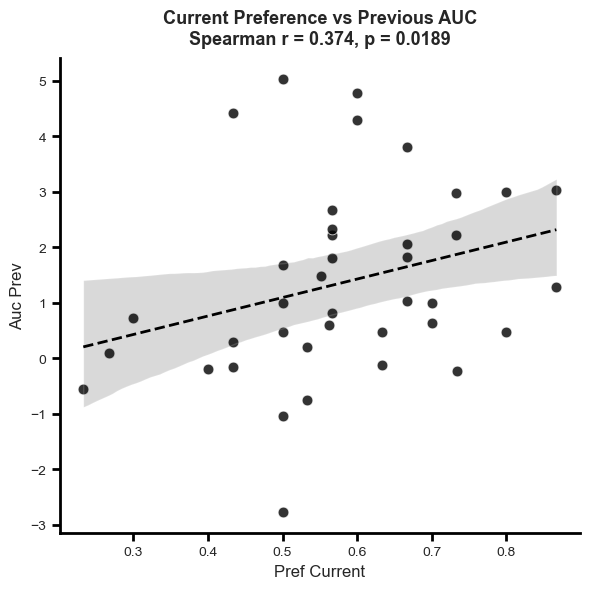

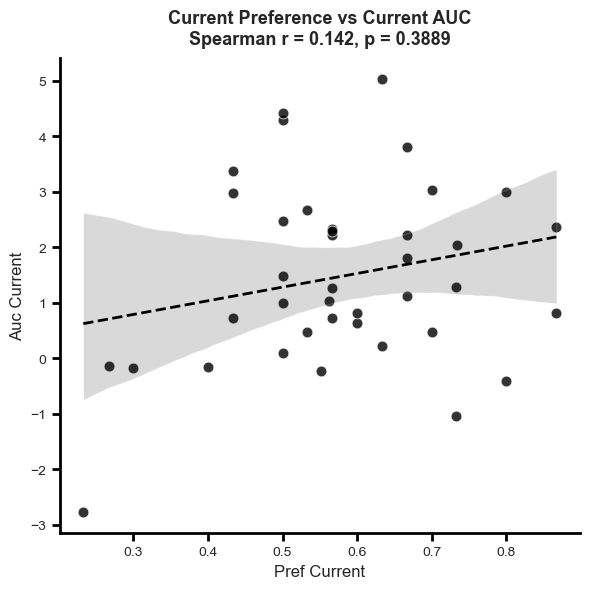

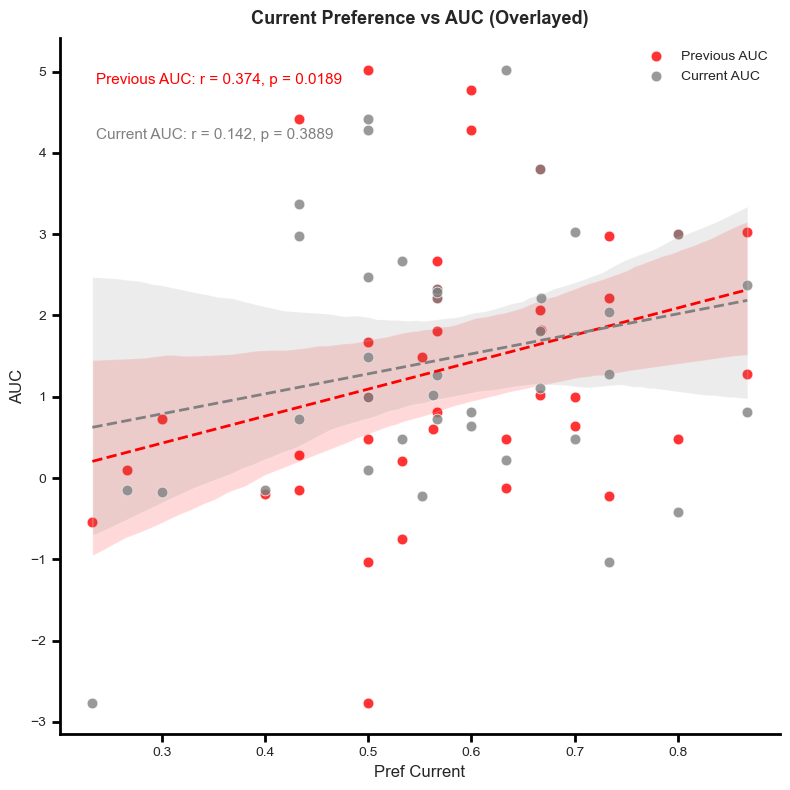

In [17]:
plot_pref_auc(combined_plot_data)